In [ ]:
import praw
import alpaca_trade_api as trade_api
from textblob import TextBlob 
import time,json, csv, re
from alpaca.trading.client import TradingClient
import pprint
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from alpaca.trading.requests import LimitOrderRequest

from alpaca.trading.client import TradingClient
from datetime import datetime
from alpaca.data import StockHistoricalDataClient, StockTradesRequest
from alpaca.trading.enums import OrderSide, TimeInForce, QueryOrderStatus
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.requests import LimitOrderRequest
from alpaca.trading.requests import GetOrdersRequest
from alpaca.data.requests import StockLatestQuoteRequest
from alpaca.data.historical import StockHistoricalDataClient
from collections import defaultdict


reddit_key = "key"
reddit_secrect = "secrect"
trading_client = TradingClient("key" , "secrect", paper = True )
data_client = StockHistoricalDataClient("key" , "secrect")

print(trading_client.get_account().buying_power)
print(trading_client.get_account().account_number)
reddit_api_client = praw.Reddit(
    client_id = reddit_key,
    client_secret = reddit_secrect,
    user_agent = "trading bot | by u/yourNamehere"

)





102569.15
PA3RXWI9SFFY


In [3]:
def get_weekly_most_recent_link():
    user = reddit_api_client.redditor("wsbapp")
    for post in user.submissions.new(limit = None):
        if "What Are Your Moves Tomorrow" in post.title:
            return post #





In [4]:
    
def extract_comments(post):
    post.comments.replace_more()
    return [comment.body for comment in post.comments ]


In [5]:

post = get_weekly_most_recent_link()
comments = extract_comments(post)




In [6]:
Stock_List = set()
#r
with open("stock.csv", "r") as f:
    reader = csv.reader(f)
    for val in list(reader)[1:]: 
        # add only ticker
        Stock_List.add(val[0])
    



In [7]:
def extract_stock_from_comment(comment):
    # Compares the words in the comment with a predefined set or list called STOCK_LIST.
    return set(re.findall(r"\w+", comment)).intersection(Stock_List)


post = get_weekly_most_recent_link()
 


In [8]:
import nltk 
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chien\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:

sia = SIA()
result = []
for comment in extract_comments(post):
    pol_score = sia.polarity_scores(comment)
    pol_score["headline"] = comment 
    # del comment from list if comment was deleted 
    if(pol_score["headline"]== "[deleted]"):
        continue
    elif (pol_score["headline"]):
        stock = set(re.findall(r"\w+", comment)).intersection(Stock_List)
        if not stock:
            continue
    result.append(pol_score)

   




In [10]:
df = pd.DataFrame.from_records(result)
df["label"] = 0 
df.loc[df["compound"] > 0.2, "label"] = 1 
df.loc[df["compound"] < -0.2, "label"] = -1 
df.head()

,neg,neu,pos,compound,headline,label
0,0.000,0.803,0.197,0.2415,WE FUCKING ON THE AMAZON BASICS BED TONIGHT BABE,1
1,0.000,0.606,0.394,0.5994,People are still doing BYND yolos lmao,1
2,0.063,0.779,0.158,0.7841,Leaked transcription of the China/US talks:\n\...,1
3,0.180,0.719,0.101,-0.4310,NFLX up 50$ because of stock split announcemen...,-1
4,0.000,0.733,0.267,0.6249,"As an AMZN holder, can’t help but feel like it...",1


In [11]:
df1 = df[['headline', 'label']]
df1.to_csv("WSB_HEADLINE.csv", encoding = 'utf-8', index = False)

C:\Users\chien\AppData\Local\Temp\ipykernel_38336\3769717107.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, ax=ax, palette=colors)
C:\Users\chien\AppData\Local\Temp\ipykernel_38336\3769717107.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])


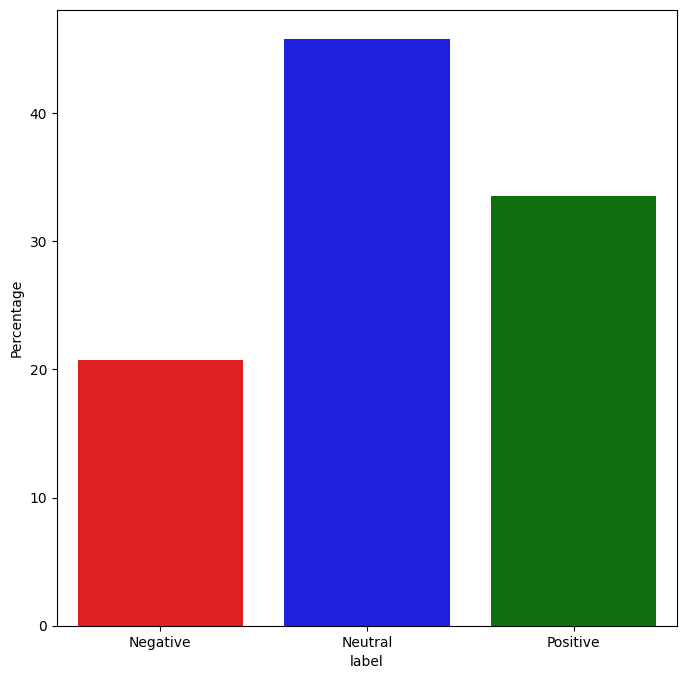

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
counts = df.label.value_counts(normalize=True) * 100
colors = ['red', 'blue', 'green']
sns.barplot(x=counts.index, y=counts, ax=ax, palette=colors)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()

In [13]:


print(trading_client.get_account().buying_power)
print(trading_client.get_account().account_number)
short_positions = {}

102569.15
PA3RXWI9SFFY


In [14]:

short_positions = defaultdict(lambda: {"amount": 0, "price": 0.0})

for index, row in df.iterrows():
    stock = extract_stock_from_comment(str(row['headline']))
    if isinstance(stock, set):
        if len(stock) == 0:
            continue
        stock = next(iter(stock))
        stock = stock.upper().strip()
    try:
        if row["label"] == 1:
            market_order_data = MarketOrderRequest(
                symbol=stock,
                qty=1,
                side=OrderSide.SELL,
                time_in_force=TimeInForce.DAY
            )
            request_params = StockLatestQuoteRequest(symbol_or_symbols=stock)
            latest_quote = data_client.get_stock_latest_quote(request_params)
            current_price = latest_quote[stock].ask_price
            short_positions[stock]["amount"] += 1
            short_positions[stock]["price"] = float(current_price)
            market_order = trading_client.submit_order(market_order_data)
        else:
            market_order_data = MarketOrderRequest(
                symbol=stock,
                qty=1,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY
            )
            market_order = trading_client.submit_order(market_order_data)
    except Exception as e:
        continue

In [ ]:
def check_signals_and_trade():
    for stock in short_positions:
        request_params = StockLatestQuoteRequest(symbol_or_symbols=stock)
        latest_quote = data_client.get_stock_latest_quote(request_params)
        current_price = latest_quote[stock].ask_price

        if current_price < short_positions[stock]["price"]:
            market_order_data = MarketOrderRequest(
                symbol=stock,
                qty=1,
                side=OrderSide.BUY,
                time_in_force=TimeInForce.DAY
            )
            market_order = trading_client.submit_order(market_order_data)

while True:
    check_signals_and_trade()
    time.sleep(60)
